#Implementation of Ankh library from Google.

Ankh protein language model is used in this notebook to generate embeddings for ScFv sequences and heavy chain sequences.

The heavy chain sequence embeddings are used as features to train a neural network to predict heavy chain V-genes. The Ankh V-gene neural network can be compared to the Ablang trained model. As suspected, Ablang does a much better job of generating embeddings that are predictive of heavy chain V-gene, ~99% vs 90% for Ankh. However, Ankh is a generalised protein language model that can be applied to full length antibodies, as well as any other protein, while Ablang can only accept single chain antibodies, either heavy or light.   

In [1]:
#@title Install and import dependencies. { display-mode: "form" }
%%capture
!pip3 install torch torchvision torchaudio transformers sentencepiece accelerate --extra-index-url https://download.pytorch.org/whl/cu116
!python -m pip install ankh
!pip install umap-learn[plot]

from sklearn.manifold import TSNE, Isomap
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from google.colab import drive
import torch, os, pandas as pd, random, matplotlib.pyplot as plt, numpy as np
import seaborn as sns
import time, random, re, shutil
import ankh
import umap

drive.mount('/content/drive/')
path = '/content/drive/MyDrive/msc-project-mbalmf01/msc-project-source-code-files-22-23-mbalmf01/notebooks'
os.chdir(path)

from plm_manipulation import start_ankh, process_seqs, batch_embed
from ML_manipulation import one_hot_labels, simple_nn
from clustering import kmeans_redux, redux_fit, redux_transform

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device: {}".format(device))

Using device: cuda:0


In [ ]:
#@title Load large Ankh model
model, tokenizer = start_ankh(device=device)

In [ ]:
#@title Embedding for heavy chain only
#@markdown 50,000 heavy chains embedded using Ankh to generate features for training a neural network.
#@markdown The labels are V-gene segment to provide a direct comparison with Ablang.
#@markdown The goal is to assess whether Ankh understands enough information to predict antibody features while enabling encoding of both heavy and light chains for paratope prediction.
#@{display-mode: "form"}

df = pd.read_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230716_human_paired_seqs.csv', dtype={'Run':np.str_}, index_col=0)
df = df.iloc[0:50000]

tensor_df = batch_embed(df=df, prot_col='sequence_alignment_aa_heavy', seq_id='seq_id', batch_size=100, model=model, tokenizer=tokenizer)

tensor_df.to_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230811_ankh_tensor_50000.csv', index=False)

In [2]:
#@title Load in sequence data and embeddings
df = pd.read_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230716_human_paired_seqs.csv', dtype={'Run':np.str_}, index_col=0)
tensor_df = pd.read_csv('/content/drive/MyDrive/msc-project-mbalmf01/all_paired/230811_ankh_tensor_50000.csv')

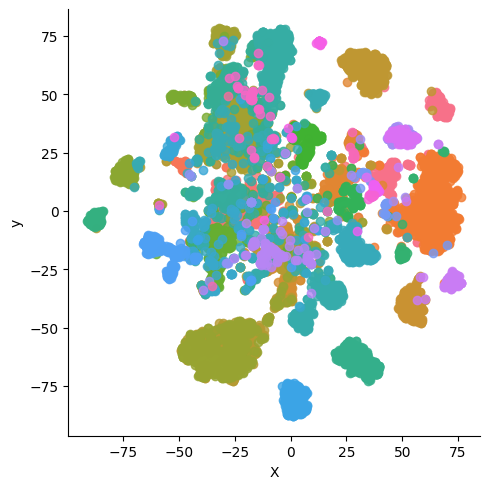

[0.5931, 0.6021, 0.5599, 0.588, 0.5588, 0.52]


In [19]:
#@title Using t-SNE and kmeans to assess latent encoding of heavy chain properties in the embedded feature space
clus_df = tensor_df.iloc[:10000, :]

new_df = redux_fit(model=TSNE, components=2, randstate=42, data=clus_df.iloc[:, :-1])
labels = df.iloc[0:10000]

new_df['cluster'] = labels['v_call_heavy'].apply(lambda x: x.split('*')[0]).to_list()

sns.lmplot(x='X', y='y', data=new_df, hue='cluster',  fit_reg=False, legend=False)
scatter_kws = {'s': 10}
plt.show()

n_clusters = [34,36,38,40,42,44]
print(kmeans_redux(n_clusters=n_clusters, model=TSNE, components=2, randstate=42, data=clus_df.iloc[:, :-1], y_true=new_df['cluster'].to_list()))

In [20]:
print(kmeans_redux(n_clusters=n_clusters, model=TSNE, components=3, randstate=42, data=clus_df.iloc[:, :-1], y_true=new_df['cluster'].to_list()))

[0.5968, 0.5887, 0.599, 0.5815, 0.5563, 0.5638]


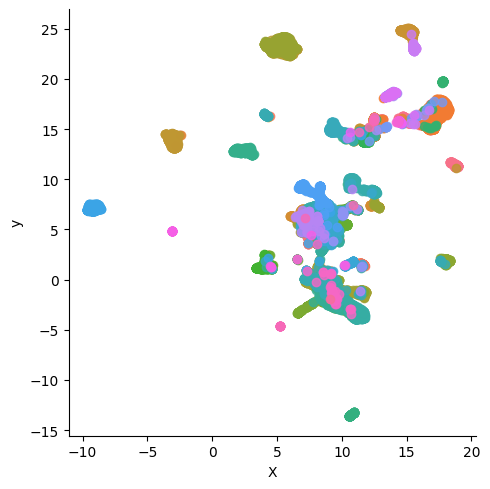

[0.6016, 0.6132, 0.6014, 0.594, 0.5859, 0.5922]


In [22]:
#@title using UMAP and kmeans to assess latent encoding of heavy chain properties in the embedded feature space
new_df = redux_fit(model=umap.UMAP, components=2, randstate=42, data=clus_df.iloc[:, :-1])
labels = df.iloc[0:10000]
new_df['cluster'] = labels['v_call_heavy'].apply(lambda x: x.split('*')[0]).to_list()

sns.lmplot(x='X', y='y', data=new_df, hue='cluster',  fit_reg=False, legend=False)
scatter_kws = {'s': 10}

plt.show()

n_clusters = [34,36,38,40,42,44]
print(kmeans_redux(n_clusters=n_clusters, model=umap.UMAP, components=2, randstate=42, data=clus_df.iloc[:, :-1], y_true=new_df['cluster'].to_list()))

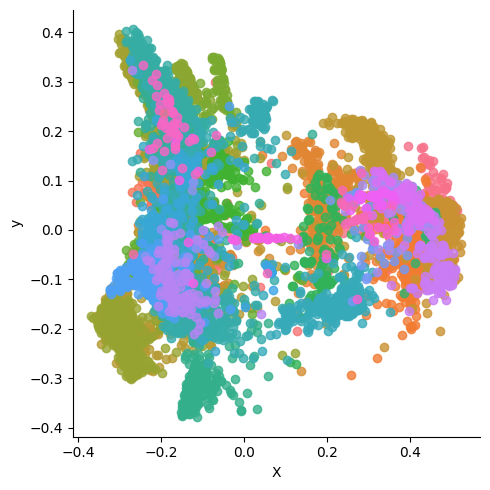

[0.4448, 0.4365, 0.4351, 0.417, 0.4146, 0.4067]


In [24]:
#@title using Isomap and kmeans to assess latent encoding of heavy chain properties in the embedded feature space
new_df = redux_fit(model=Isomap, components=2, randstate=42, data=clus_df.iloc[:, :-1])
labels = df.iloc[0:10000]
new_df['cluster'] = labels['v_call_heavy'].apply(lambda x: x.split('*')[0]).to_list()

sns.lmplot(x='X', y='y', data=new_df, hue='cluster',  fit_reg=False, legend=False)
scatter_kws = {'s': 10}

plt.show()

n_clusters = [34,36,38,40,42,44]
print(kmeans_redux(n_clusters=n_clusters, model=Isomap, components=2, randstate=42, data=clus_df.iloc[:, :-1], y_true=new_df['cluster'].to_list()))

In [25]:
print(kmeans_redux(n_clusters=n_clusters, model=Isomap, components=4, randstate=42, data=clus_df.iloc[:, :-1], y_true=new_df['cluster'].to_list()))

[0.5117, 0.5352, 0.4862, 0.4929, 0.5023, 0.4769]


In [10]:
df = df[df['seq_id'].isin(tensor_df['seq_id'].to_list())]

In [11]:
df['seq_id'].to_list() == tensor_df['seq_id'].to_list()

True

In [12]:
#@title Split embeddings into training, validation and testing sets
np.random.RandomState(42)
embeddings = tensor_df.iloc[:,:-1]
labels = df['v_call_heavy'].apply(lambda x: x.split('*')[0])
num_classes = len(np.unique(labels))
labels_encoded = one_hot_labels(labels)

X_train = embeddings.iloc[:35000, :]
y_train = labels_encoded[:35000, :]

X_val = embeddings.iloc[35000:45000, :]
y_val = labels_encoded[35000:45000, :]

X_test = embeddings.iloc[45000:50000,:]
y_test = labels_encoded[45000:50000,:]

In [15]:
#@title Build and train model
#@title Build and train model

#build model
model = simple_nn(X_train.shape[1], num_classes)
#train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
1094/1094 [==============================] - 5s 4ms/step - loss: 2.1246 - accuracy: 0.3910 - val_loss: 1.1508 - val_accuracy: 0.6471
Epoch 2/10
1094/1094 [==============================] - 4s 3ms/step - loss: 1.2295 - accuracy: 0.6159 - val_loss: 0.7222 - val_accuracy: 0.7849
Epoch 3/10
1094/1094 [==============================] - 4s 3ms/step - loss: 0.9484 - accuracy: 0.7025 - val_loss: 0.5455 - val_accuracy: 0.8339
Epoch 4/10
1094/1094 [==============================] - 4s 3ms/step - loss: 0.8037 - accuracy: 0.7435 - val_loss: 0.4719 - val_accuracy: 0.8498
Epoch 5/10
1094/1094 [==============================] - 4s 3ms/step - loss: 0.7102 - accuracy: 0.7695 - val_loss: 0.4196 - val_accuracy: 0.8574
Epoch 6/10
1094/1094 [==============================] - 4s 3ms/step - loss: 0.6461 - accuracy: 0.7901 - val_loss: 0.3657 - val_accuracy: 0.8787
Epoch 7/10
1094/1094 [==============================] - 4s 3ms/step - loss: 0.5903 - accuracy: 0.8067 - val_loss: 0.3476 - val_accuracy:

In [16]:
#@title Assess model on validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_true_classes, y_pred_classes, zero_division=1))

313/313 [==============================] - 1s 1ms/step
Accuracy: 0.9019

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       306
           1       0.83      0.97      0.90        62
           2       1.00      0.96      0.98        83
           3       0.91      0.95      0.93       287
           4       1.00      0.00      0.00         3
           5       0.96      0.85      0.90       229
           6       1.00      0.66      0.79        35
           7       0.99      0.98      0.98       300
           8       0.97      0.90      0.93       100
           9       1.00      0.95      0.98        83
          10       0.96      1.00      0.98       219
          11       1.00      0.79      0.88        29
          12       0.93      0.88      0.90       171
          13       0.97      0.87      0.92        39
          14       0.98      0.99      0.98       334
          15       1.00      0.81     

In [17]:
#@title Assessing the model on totally unseen data
#Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

#Basic Metrics
print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_true_classes, y_pred_classes, zero_division=1))

157/157 [==============================] - 0s 1ms/step
Accuracy: 0.8988

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       160
           1       0.70      0.87      0.78        38
           2       1.00      0.91      0.95        34
           3       0.88      0.93      0.90       143
           4       1.00      0.00      0.00         1
           5       0.97      0.84      0.90       101
           6       1.00      0.58      0.73        19
           7       0.97      0.98      0.97       124
           8       0.93      0.98      0.95        54
           9       0.97      0.97      0.97        35
          10       0.98      1.00      0.99       121
          11       1.00      0.81      0.90        16
          12       0.93      0.86      0.89        99
          13       0.93      0.74      0.82        19
          14       0.95      0.99      0.97       150
          15       1.00      1.00     

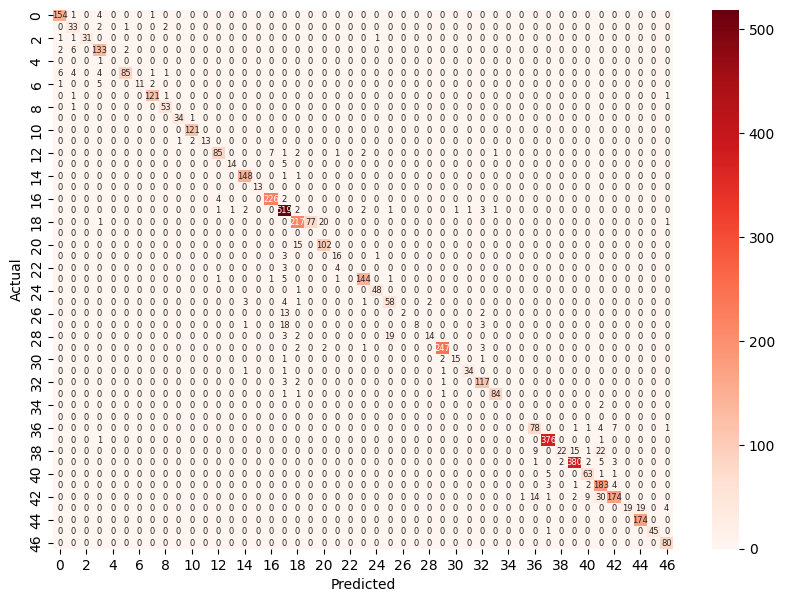

In [21]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', annot_kws={"size": 6},cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/msc-project-mbalmf01/msc-project-source-code-files-22-23-mbalmf01/ankh_V_gene_model.h5')